# Code for comparison of standard CRC and generalized CRC on synthetic non-monotonic losses
## (for Figure 2 in "Conformal Policy Control" paper by Prinster, et al., 2026)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [25]:
'''
Experiment setup is inspired by Proposition 1 of CRC paper (Angelopoulos, et al., 2024)
'''

B = 1 ## Bound for loss function
N = 100 ## Cardinality of hyperparameter space, Lambda
Lambda = np.linspace(0, 1, N) ## Hyperparameter space, Lambda
n = 10 ## Number of calibration samples
num_expts = 1000 ## Number of experiments


## Piecewise loss function, as defined in Proposition 1 of CRC paper
def piecewise_loss(lmbda, p, alpha=None, n=None, num_samples=1):
    if lmbda == 1:
        ## If lambda is most conservative, ie, lambda_{max}
        return np.zeros(num_samples)
    else:
        return np.random.binomial(1, p, size=num_samples)

def piecewise_loss_more_difficult(lmbda, p, alpha, n=10, B=1, num_samples=1):
    if lmbda == 1:
        ## lambda_{max}
        ## Made this condition more difficult, as largest loss s.t. \hat{\lambda} still exists (s.t. risk controlling lambdas is not empty set)
        if num_samples == 1 and ((n+1) * alpha - B)/n < 0:
            print(f"loss : {((n+1) * alpha - B)/n}, alpha = {alpha}, n={n}, B={B}")
            
        return ((n+1) * alpha - B)/n * np.ones(num_samples)
        
    else:
        return np.random.binomial(1, p, size=num_samples)

## Most dificult loss function, inspired by Proposition 1 of CRC paper
def piecewise_loss_most_difficult(lmbda, p, alpha, n=None, num_samples=1):
    if lmbda == 1:
        ## lambda_{max}
        ## Made this condition most difficult, as loss=alpha
        return alpha * np.ones(num_samples)
        
    else:
        return np.random.binomial(1, p, size=num_samples)


## 1. Counterexample experiment showing that CRC fails to control the risk for a non-monotone loss

In [26]:
'''
Implementing counterexample given in Proposition 1 of CRC paper
'''
index_lmbda_selected_all = []
crc_risks = []
crc_risks_stderr = []
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

loss_function_name = "piecewise_loss_more_difficult" # "piecewise_loss", "piecewise_loss_more_difficult", "piecewise_loss_most_difficult"

for alpha in alphas:
    print(f'alpha : {alpha}')

    test_pt_losses = []
    num_lmbda_searched_all = []
    
    for e, expt in enumerate(range(num_expts)): 
    
        lmbda_prev = 1.0
        num_lmbda_searched_all.append(0)
        
        for l, lmbda in enumerate(Lambda): 
            # p = max(min(np.cos(l)/50 + (alpha + 1) * 0.6 * (len(Lambda) - l) / len(Lambda), 1), 0)
            p = max(min(np.cos(l)/50 + (alpha + 1) * 0.6 * (1-lmbda), 1), 0)

            L = eval(loss_function_name)(lmbda, p, alpha=alpha, n=n, num_samples=n)
        
            if np.sum(L) / (n + 1) + B / (n + 1) <= alpha: 
                index_lmbda_selected_all.append(l)
                test_pt_losses.append(eval(loss_function_name)(lmbda, p, alpha=alpha, n=n, num_samples=1))
                break
    
            num_lmbda_searched_all[e] += 1
            lmbda_prev = lmbda
    
    test_pt_loss_mean = np.mean(test_pt_losses)
    crc_risks.append(test_pt_loss_mean)
    test_pt_loss_CI_length = np.std(test_pt_losses) / np.sqrt(num_expts)
    crc_risks_stderr.append(test_pt_loss_CI_length)

    ## Check if risk is not controlled (adjusting for 95% CI)
    if np.mean(test_pt_losses) - test_pt_loss_CI_length > alpha:
        print(f'\t p = {round(p, 3)}  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = {round(test_pt_loss_mean, 5)} +/- ({round(test_pt_loss_CI_length,5)}) > {alpha} = alpha')
    else:
        print(f"\t p = {round(p, 3)}  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ {round(test_pt_loss_mean, 5)} +/- ({round(test_pt_loss_CI_length, 5)}) <= {alpha} = alpha")
        
    print("\n")
crc_risks = np.array(crc_risks)
crc_risks = np.array(crc_risks)


alpha : 0.1
	 p = 0.327  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.242 +/- (0.01354) > 0.1 = alpha


alpha : 0.2
	 p = 0.418  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.363 +/- (0.01521) > 0.2 = alpha


alpha : 0.3
	 p = 0.494  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.514 +/- (0.01581) > 0.3 = alpha


alpha : 0.4
	 p = 0.514  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.564 +/- (0.01568) > 0.4 = alpha


alpha : 0.5
	 p = 0.68  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.643 +/- (0.01515) > 0.5 = alpha


alpha : 0.6
	 p = 0.666  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.733 +/- (0.01399) > 0.6 = alpha


alpha : 0.7
	 p = 0.765  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.795 +/- (0.01277) > 0.7 = alpha


alpha : 0.8
	 p = 0.82  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = 0.867 +/- (0.01074) > 0.8 = alpha


alpha : 0.9
	 p = 0.864  :

## 2. However, in the same experimental setting, generalized CRC *does* control the risk

In [27]:
###### generalized CRC (proposed)

index_lmbda_selected_all = []
gcrc_risks = []
gcrc_risks_stderr = []

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for alpha in alphas:
    print(f'alpha : {alpha}')

    test_pt_losses = []
    num_lmbda_searched_all = []
    
    for e, expt in enumerate(range(num_expts)): 
    
        lmbda_prev = 1.0
        num_lmbda_searched_all.append(0)
        
        for l, lmbda in enumerate(Lambda[::-1]): ## Reverse order of test, to go from most conservative to least conservative
            p = max(min(np.cos(l)/50 + (alpha + 1) * 0.6 * (1-lmbda), 1), 0)

            L = eval(loss_function_name)(lmbda, p, alpha=alpha, n=n, num_samples=n)
        
            ## Check if lmbda does not satisfy risk control (stopping criterion)
            if np.sum(L) / (n + 1) + B / (n + 1) > alpha: ## Check if does not satisfy risk control
                index_lmbda_selected_all.append(l)
                # if eval(loss_function_name)(lmbda_prev, p, alpha=alpha, num_samples=1) < 0:
                #     print(eval(loss_function_name)(lmbda_prev, p, alpha=alpha, num_samples=1))
                test_pt_losses.append(eval(loss_function_name)(lmbda_prev, p, alpha=alpha, n=n, num_samples=1)) ## Select most recent lambda, not current one
                break
    
            num_lmbda_searched_all[e] += 1
            lmbda_prev = lmbda
    
    test_pt_loss_mean = np.mean(test_pt_losses)
    gcrc_risks.append(test_pt_loss_mean)
    test_pt_loss_CI_length = np.std(test_pt_losses) / np.sqrt(num_expts)
    gcrc_risks_stderr.append(test_pt_loss_CI_length)


    ## Check if risk is not controlled (adjusting for 95% CI)
    if np.mean(test_pt_losses) - test_pt_loss_CI_length > alpha:
        print(f'\t p = {round(p, 3)}  :  (!) RISK NOT CONTROLLED (!) : mean L_(n+1)(\hat\lambda) = {round(test_pt_loss_mean, 5)} +/- ({round(test_pt_loss_CI_length,5)}) > {alpha} = alpha')
    else:
        print(f"\t p = {round(p, 3)}  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ {round(test_pt_loss_mean, 5)} +/- ({round(test_pt_loss_CI_length, 5)}) <= {alpha} = alpha")
    
    print("\n")

gcrc_risks = np.array(gcrc_risks)
gcrc_risks_stderr = np.array(gcrc_risks_stderr)

alpha : 0.1
	 p = 0.059  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.03977 +/- (0.00604) <= 0.1 = alpha


alpha : 0.2
	 p = 0.02  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.12 +/- (0.0) <= 0.2 = alpha


alpha : 0.3
	 p = 0.045  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.142 +/- (0.01104) <= 0.3 = alpha


alpha : 0.4
	 p = 0.184  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.215 +/- (0.01299) <= 0.4 = alpha


alpha : 0.5
	 p = 0.18  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.267 +/- (0.01399) <= 0.5 = alpha


alpha : 0.6
	 p = 0.447  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.386 +/- (0.01539) <= 0.6 = alpha


alpha : 0.7
	 p = 0.34  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.466 +/- (0.01577) <= 0.7 = alpha


alpha : 0.8
	 p = 0.434  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.565 +/- (0.01568) <= 0.8 = alpha


alpha : 0.9
	 p = 0.506  :  Risk controlled : mean $L_(n+1)(\hat\lambda)$ 0.656 +/- (0.01502) <= 0.9 = alpha




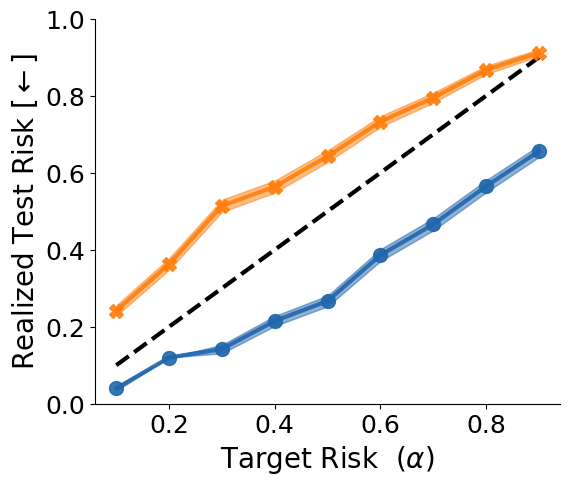

In [28]:
'''
Plot risk control comparison across alphas
'''

BLUE = '#2166ac'

fig, ax = plt.subplots(figsize=(6, 5))

axlabelsize=20
ticklabelsize=18
markersize=10
linewidth=3
ax.tick_params(axis='both', labelsize=ticklabelsize)

ax.plot(alphas, alphas, color='black', linestyle = '--', linewidth=3, label='Target Risk Upper Bound')


## Plot CRC
ax.fill_between(alphas, crc_risks - crc_risks_stderr, crc_risks + crc_risks_stderr, alpha = 0.5, color='C1')
ax.plot(alphas, crc_risks, marker='X', label= 'Standard CRC \n(Angelopoulous, et al., 2024)', linewidth=linewidth, markersize=markersize, color='C1', alpha=0.9)


## Plot GCRC
ax.fill_between(alphas, gcrc_risks - gcrc_risks_stderr, gcrc_risks + gcrc_risks_stderr, alpha = 0.5, color=BLUE)
ax.plot(alphas, gcrc_risks, marker='o', label= 'Generalized CRC (Proposed)', linewidth=linewidth, markersize=markersize, color=BLUE, alpha=0.9)



ax.set_ylabel(r'Realized Test Risk [$\leftarrow$]', fontsize=axlabelsize)
ax.set_xlabel(r'Target Risk  ($\alpha$)', fontsize=axlabelsize)
# ax.legend()
ax.set_ylim([0,1])
ax.spines[['right', 'top']].set_visible(False)
fig.savefig(f'counterexample_{loss_function_name}Loss.pdf', bbox_inches='tight', dpi=300)


['Target Risk Upper Bound ($\\alpha$)', 'True Risk', '(Conservative) Empirical Risk', 'Standard CRC', 'GCRC (proposed)']


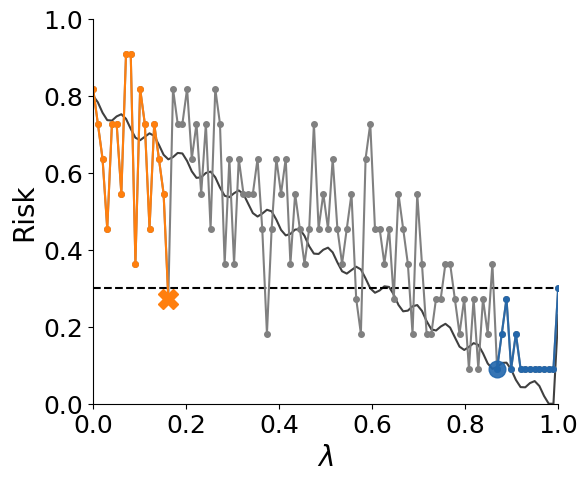

In [29]:
'''
Risk trajectory plotting
'''
index_lmbda_selected_all = []

n=10
alpha = 0.3
p = 0.6

lmbda_prev = 1.0

cal_risks = np.zeros(len(Lambda))
cal_losses = np.zeros((n, len(Lambda)))
true_risks = np.zeros(len(Lambda))

for l, lmbda in enumerate(Lambda): ## Reverse order of test, to go from most conservative to least conservative
    p = max(min(np.cos(l)/50 + (alpha + 1) * 0.6 * (1-lmbda), 1), 0)

    true_risks[l] = p if lmbda < 1 else ((n+1) * alpha - B)/n
    
    L = eval(loss_function_name)(lmbda, p, alpha=alpha, n=n, num_samples=n)
    cal_losses[:, l] = L

    cal_risks[l] = np.sum(L) / (n + 1) + B / (n + 1)

## Finding CRC lambda solution:
for l, lmbda in enumerate(Lambda):
    if cal_risks[l] <= alpha:
        crc_l = l
        break

## Finding GCRC lambda solution:
l_prev = -1
for l, lmbda in enumerate(Lambda[::-1]):
    gcrc_l = -(l+1)
    if cal_risks[gcrc_l] > alpha:
        gcrc_l += 1
        break

fig, ax = plt.subplots(figsize=(6, 5))

axlabelsize=20
ticklabelsize=18
ax.tick_params(axis='both', labelsize=ticklabelsize)

ax.axhline(alpha, linestyle='--', label=r'Target Risk Upper Bound ($\alpha$)', color='black')

ax.plot(Lambda, true_risks, color='black', label='True Risk', alpha=0.75)
ax.plot(Lambda, cal_risks, marker='o', markersize=4, label=r'(Conservative) Empirical Risk', color='gray')

ax.plot(Lambda[:crc_l+1], cal_risks[:crc_l+1], marker='o', markersize=4,  color='C1')
ax.plot(Lambda[gcrc_l:], cal_risks[gcrc_l:], marker='o', markersize=4,   color=BLUE, alpha=0.9)


ax.plot(Lambda[crc_l], cal_risks[crc_l], label=r'Standard CRC', color='C1', markersize=14, marker='X')
ax.plot(Lambda[gcrc_l], cal_risks[gcrc_l], marker='o', markersize=12, label=r'GCRC (proposed)', color=BLUE, alpha=0.9)


ax.set_xlabel(f'$\lambda$', fontsize=axlabelsize)
ax.set_ylabel('Risk', fontsize=axlabelsize)
ax.set_ylim([0, 1.0])
ax.set_xlim([0, 1.0])
# ax.legend()
ax.spines[['right', 'top']].set_visible(False)
fig.savefig('empirical_risk_trajectory.pdf', bbox_inches='tight', dpi=300)



handles, labels = ax.get_legend_handles_labels()
print(labels)
leg1 = ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(0.5, 1.05), ncols=3, frameon=False)
ax.add_artist(leg1)
legend_extent1 = leg1.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
leg1.set_in_layout(False)
fig.savefig(f'legend1_crc_counterexample.pdf', bbox_inches=legend_extent1, dpi=300)
